# Yelp Data Challenge - Restaurant Recommender

BitTiger DS501

Nov 2017

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#% matplotlib inline
plt.style.use("ggplot")

In [2]:
df = pd.read_csv('data/last_3_years_restaurant_reviews.csv')

In [3]:
df.head(2)

,business_id,name,categories,avg_stars,cool,date,funny,review_id,stars,text,useful,user_id
0,LDMCrFlGIFUN6L-FEFgzWg,El Pollo Loco,"['Restaurants', 'American (Traditional)', 'Mex...",3.0,0,2015-06-26,0,4gH-5f0ewrH2Vvl0UYtQQA,1,I'm at training for work and went for a quick ...,0,GLGz9sSNHIbguwv90XStYA
1,LDMCrFlGIFUN6L-FEFgzWg,El Pollo Loco,"['Restaurants', 'American (Traditional)', 'Mex...",3.0,2,2015-06-18,1,qlnMpBo8_GWhlJE6zR51qA,3,Given this location is close to my work I find...,2,YxqLJwDgcL4OoDB1hN-Ikg


## 1. Clean data and get rating data 

#### Select relevant columns in the original dataframe

In [4]:
# Get business_id, user_id, stars for recommender

df_stars = df[['business_id', 'user_id', 'stars']]

In [5]:
# stars distribution
df_stars['stars'].value_counts()

5    200192
4     95150
1     55374
3     49687
2     37121
Name: stars, dtype: int64

In [6]:
df_stars['business_id'].nunique() # number of unique elements

4622

In [7]:
# number of unique user_id
df_stars['user_id'].nunique()

195779

In [8]:
# user comments counts
df_user_counts = df_stars['user_id'].value_counts()
df_user_counts.head()

bLbSNkLggFnqwNNzzq-Ijw    681
JaqcCU3nxReTW2cBLHounA    296
PKEzKWv_FktMm2mGPjwd0Q    247
B1829_hxXSEpDPEDJtYeIw    242
U4INQZOPSUaj8hMjLlZ3KA    205
Name: user_id, dtype: int64

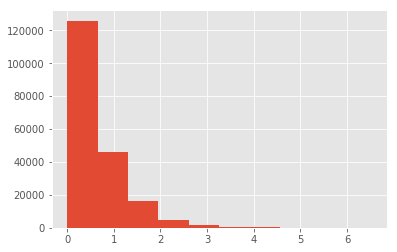

In [9]:
# display log histogram
# df_user_counts.hist()
df_user_counts.apply(np.log).hist()
plt.show()

#### There are many users that haven't given many reviews, exclude these users from the item-item similarity recommender

**Q**: How do we recommend to these users anyways?

In [10]:
# how many users only comments once
df_user_counts[df_user_counts == 1].sum()

125817

In [11]:
# users comment over 5 times
df_users = df_user_counts[df_user_counts > 5]

In [12]:
# count users comment over 5 times as active user
df_users.count()

12251

In [13]:
# sum of all comments
df_users.sum()

154308

In [14]:
# display active user id
df_users.index

Index([u'bLbSNkLggFnqwNNzzq-Ijw', u'JaqcCU3nxReTW2cBLHounA',
       u'PKEzKWv_FktMm2mGPjwd0Q', u'B1829_hxXSEpDPEDJtYeIw',
       u'U4INQZOPSUaj8hMjLlZ3KA', u'3nIuSCZk5f_2WWYMLN7h3w',
       u'qPVtjjp8sNQ32p9860SR9Q', u'OXSJCjKtvZPf-YPDCXcWZg',
       u'VigsAph76fP7pechJ743EA', u'JYcCYNWs8Ul6ewG5kCYW4Q',
       ...
       u'shTVQJhu-NftZfRTUxYxrg', u'-ncZUYDGivYLa6wwP2tqCA',
       u'int2r_0j2HoSkESXz20QSA', u'rJtmzioJOpNCqV5mCMt34Q',
       u'yr6U0Wk8LXR_OLF1ezHOhw', u'XC6xHcptE6RB4f7gu692-A',
       u'D307JOQoPLOiaZVLQORptA', u'ROsAs833CTExJfWotUyY9Q',
       u'VFLZbmiPsAl57Q2nQmr3SQ', u'ndV0TFet3hr93O-xOkBDww'],
      dtype='object', length=12251)

In [15]:
# reorder dataframe
df_stars_cleaned = df_stars.set_index('user_id').loc[df_users.index].reset_index()
df_stars_cleaned.head()

,user_id,business_id,stars
0,bLbSNkLggFnqwNNzzq-Ijw,TYGVaav4hWZioQlk9Ig78A,4
1,bLbSNkLggFnqwNNzzq-Ijw,3PshdJtSwd_poaPL7fIOHg,2
2,bLbSNkLggFnqwNNzzq-Ijw,q3oJ6bNRV3OoJrwc95GOwg,4
3,bLbSNkLggFnqwNNzzq-Ijw,aBLQxmSlqkahg0BEokTPKw,3
4,bLbSNkLggFnqwNNzzq-Ijw,Ang2kQwTBd9S4LrhAS2pCA,4


#### Create utility matrix from records

In [16]:
# convert to document, word like matrix
df_utility = pd.pivot_table(data=df_stars_cleaned,
                            values='stars', # fill with stars
                            index='user_id', # rows
                            columns='business_id', # columns
                            fill_value=0) # fill missings

In [17]:
df_utility.head()

business_id,--9e1ONYQuAa-CB_Rrw7Tw,-1vfRrlnNnNJ5boOVghMPA,-3zffZUHoY8bQjGfPSoBKQ,-8R_-EkGpUhBk55K9Dd4mg,-9YyInW1wapzdNZrhQJ9dg,-AD5PiuJHgdUcAK-Vxao2A,-BS4aZAQm9u41YnB9MUASA,-Bf8BQ3yMk8U2f45r2DRKw,-BmqghX1sv7sgsxOIS2yAg,-Bv-HHUs8aHzDrdWcZHn8w,...,zmltWmTpoBt5sCU-5Kzj-Q,znWHLW1pt19HzW1VY6KfCA,zp-K5s3pGTWuuaVBWo6WZA,zpoZ6WyQUYff18-z4ZU1mA,zrQ1zKWC-W2PCvwjBururQ,zsQk990PubOHjr1YcLkQFw,zt9RLUIU32fZYOBh2L0NNQ,zttcrQP4MxNS5X5itzStXg,zuwba6QEBIDZT0tJZmNhdQ,zwNC-Ow4eIMan2__bS9-rg
user_id,,,,,,,,,,,,,,,,,,,,,
--LUapetRSkZpFZ2d-MXLQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--RlSfc-QmcHFGHyX6aVjA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--ZNfWKj1VyVElRx6-g1fg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
-00kdEIhCt-ODaV4BS-EAg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-05XqtNjcBq19vh2CVJN8g,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# get the list of user id by checking out the index of the utility matrix
user_id_list = df_utility.index
user_id_list.shape

(12251L,)

In [19]:
# get the list of item id by checking out the columns of the utility matrix
item_id_list = df_utility.columns
item_id_list.shape

(4340L,)

## 2. Item-Item similarity recommender

In [20]:
import graphlab

### Let's reuse the ItemItemRecommender class derived from previous exercise

Hint: we need to make modification to accommodate the dense numpy array

In [21]:
# To be implemented

sf_stars = graphlab.SFrame(df_stars)
sf_stars # SFrame similar to DataFrame

This non-commercial license of GraphLab Create for academic use assigned to kxl162530@utdallas.edu has expired. Please contact contact@turi.com for renewal options.


InvalidLicense: License check failed.

## 3. Content-based recommender
### extract some feature for recommender¶

In [23]:
# group by business_id, then average numerical features

df_average = df.groupby(['business_id']).mean()
df_average.head()

,avg_stars,cool,funny,stars,useful
business_id,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,4.0,0.690176,0.521411,4.141058,0.959698
-1vfRrlnNnNJ5boOVghMPA,3.0,0.357143,0.428571,3.000000,0.357143
-3zffZUHoY8bQjGfPSoBKQ,4.0,0.503145,0.440252,3.880503,0.943396
-8R_-EkGpUhBk55K9Dd4mg,3.5,0.877551,0.775510,3.714286,1.000000
-9YyInW1wapzdNZrhQJ9dg,2.5,0.162162,0.229730,2.378378,0.608108


In [24]:
# group by business_id, extract categories data

categories_series = df.groupby(['business_id']).categories.apply(np.unique)
categories_series.head()

business_id
--9e1ONYQuAa-CB_Rrw7Tw     [['Steakhouses', 'Cajun/Creole', 'Restaurants']]
-1vfRrlnNnNJ5boOVghMPA            [['Restaurants', 'Korean', 'Sushi Bars']]
-3zffZUHoY8bQjGfPSoBKQ    [['Seafood', 'Bars', 'Nightlife', 'American (N...
-8R_-EkGpUhBk55K9Dd4mg                            [['Restaurants', 'Thai']]
-9YyInW1wapzdNZrhQJ9dg                         [['Buffets', 'Restaurants']]
Name: categories, dtype: object

In [25]:
# convert categories data to string remove `[]`
categories_series = categories_series.str.join('').apply(lambda x: x[1:-1])

In [26]:
# business_id, categories table
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
categories_mat = vectorizer.fit_transform(categories_series).toarray()
categories = vectorizer.get_feature_names()
df_categories = pd.DataFrame(categories_mat,
                             columns=categories, 
                             index=categories_series.index)
df_categories.head()

,acai,active,activities,acupuncture,adult,afghan,african,air,aircraft,airport,...,wholesalers,windshield,wine,wineries,wings,women,wraps,yoga,yogurt,yourself
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-1vfRrlnNnNJ5boOVghMPA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-3zffZUHoY8bQjGfPSoBKQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-8R_-EkGpUhBk55K9Dd4mg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-9YyInW1wapzdNZrhQJ9dg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# use svd to reduce dimension
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=150,
                   random_state=42)

svd.fit(categories_mat)
categories_svd = svd.transform(categories_mat)
df_categories_svd = pd.DataFrame(categories_svd,
                                 index=categories_series.index)

print(svd.explained_variance_ratio_.sum()) # total variance explained
df_categories_svd.head()

0.983172691228


,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,0.733607,0.048297,-0.448549,-0.437559,0.022083,0.032606,0.055533,-0.083950,0.052735,0.016879,...,-0.004664,0.001612,-0.010167,-0.002571,-0.002431,0.007489,0.006239,0.014478,-0.000528,-0.004206
-1vfRrlnNnNJ5boOVghMPA,1.018333,0.618293,0.175823,-0.700042,-0.088436,0.132244,0.071544,-0.041026,0.270472,0.031403,...,0.004636,0.004252,0.004675,-0.008710,-0.002977,-0.002700,0.011117,0.001308,0.005569,-0.004438
-3zffZUHoY8bQjGfPSoBKQ,1.493956,1.363523,0.008569,0.206970,-0.058353,-0.205155,0.151758,-0.247623,-0.094861,0.450903,...,-0.004687,0.001918,0.005880,0.005624,0.002004,-0.010276,-0.006163,-0.006179,-0.006675,0.002420
-8R_-EkGpUhBk55K9Dd4mg,0.712398,0.014550,-0.441883,-0.456053,0.011848,0.056086,0.058180,-0.091267,0.076697,0.013932,...,0.004926,-0.003781,-0.002440,0.005752,-0.003496,-0.001955,0.007107,-0.001205,0.008579,-0.003614
-9YyInW1wapzdNZrhQJ9dg,0.709960,0.023327,-0.447403,-0.443387,0.014533,0.049721,0.043035,-0.060953,0.049548,0.000715,...,0.000904,-0.001926,0.002280,-0.001049,-0.005937,-0.000290,-0.005040,-0.000868,0.002880,-0.002284


In [30]:
# display feature matrix dimension

print('df_average : ', df_average.shape)
print('df_categories : ', df_categories.shape)
print('df_categories_svd : ', df_categories_svd.shape)

df_average :  (4622, 5)
df_categories :  (4622, 441)
df_categories_svd :  (4622, 150)


In [31]:
# join two to generate feature data for each business_id

df_business = df_average.join(df_categories_svd)

In [33]:
print(df_business.shape)
df_business.head()

(4622, 155)


,avg_stars,cool,funny,stars,useful,0,1,2,3,4,...,140,141,142,143,144,145,146,147,148,149
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,4.0,0.690176,0.521411,4.141058,0.959698,0.733607,0.048297,-0.448549,-0.437559,0.022083,...,-0.004664,0.001612,-0.010167,-0.002571,-0.002431,0.007489,0.006239,0.014478,-0.000528,-0.004206
-1vfRrlnNnNJ5boOVghMPA,3.0,0.357143,0.428571,3.000000,0.357143,1.018333,0.618293,0.175823,-0.700042,-0.088436,...,0.004636,0.004252,0.004675,-0.008710,-0.002977,-0.002700,0.011117,0.001308,0.005569,-0.004438
-3zffZUHoY8bQjGfPSoBKQ,4.0,0.503145,0.440252,3.880503,0.943396,1.493956,1.363523,0.008569,0.206970,-0.058353,...,-0.004687,0.001918,0.005880,0.005624,0.002004,-0.010276,-0.006163,-0.006179,-0.006675,0.002420
-8R_-EkGpUhBk55K9Dd4mg,3.5,0.877551,0.775510,3.714286,1.000000,0.712398,0.014550,-0.441883,-0.456053,0.011848,...,0.004926,-0.003781,-0.002440,0.005752,-0.003496,-0.001955,0.007107,-0.001205,0.008579,-0.003614
-9YyInW1wapzdNZrhQJ9dg,2.5,0.162162,0.229730,2.378378,0.608108,0.709960,0.023327,-0.447403,-0.443387,0.014533,...,0.000904,-0.001926,0.002280,-0.001049,-0.005937,-0.000290,-0.005040,-0.000868,0.002880,-0.002284


## 3. Matrix Factorization recommender

Take a look at Graphlab Create examples

## 4. Other recommenders (optional)

What are other ways you can build a better recommender?

* Other features (have you noticed there are other features in the Yelp dataset, e.g. tips, etc.?)
* Popularity-based
* Content-based
* Hybrid